In [1]:
import numpy as np
import scipy
import math

In [2]:
# !pip install optuna
# import optuna
# optuna.logging.set_verbosity(optuna.logging.WARNING)


# def objective(trial):
#     # Suggest integer values for x1, x2, x3
#     x1 = trial.suggest_int("x1", 0, 50)
#     x2 = trial.suggest_int("x2", 0, 50)
#     x3 = trial.suggest_int("x3", 0, 54)
#     x4 = trial.suggest_int("x4", 0, 76)
#     x5 = trial.suggest_int("x5", 0, 233)

#     # Compute y (must be non-negative)
#     y = 1000 - x1 - x2 - x3 - x4 - x5

#     # Penalize invalid cases where y < 0
#     if y < 0:
#         return float('inf')  # Invalid solution

#     # Compute the objective function
#     cost = 200*x1 + 54*x2 + 31*x3 + 80*x4 + 10000000*x5 + 21*y**3
#     return cost

# # Create a study and optimize
# study = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler(seed=228))
# study.optimize(objective, n_trials=3000, show_progress_bar=True)  # Adjust n_trials for better convergence

# # Print the best solution
# # Print the best solution
# print("Best trial:")
# trial = study.best_trial
# print(f"  x1: {trial.params['x1']}")
# print(f"  x2: {trial.params['x2']}")
# print(f"  x3: {trial.params['x3']}")
# print(f"  x4: {trial.params['x4']}")
# print(f"  x5: {trial.params['x5']}")
# print(f"  y: {1000 - trial.params['x1'] - trial.params['x2'] - trial.params['x3']-trial.params['x4']-trial.params['x5']}")
# print(f"  Objective value: {trial.value}")

In [74]:
def solve_one_dimensional_problem(a: int, b: np.ndarray, c: np.ndarray, d: int, r: int, is_logging=False, k=-1, s=-1):
    '''
    c1*x1 + c2*x2 + ... + cn*xn + d*y^r -> min, xi <= min(a, bi)
    '''
    x_sol = [0] * c.size
    y_sol = 0
    score = 0

    max_vol = a

    c_less_j = np.where(c < d)[0]
    c_less_j_sorted = c_less_j[np.argsort(c[c_less_j])]

    c_greater_j = np.where(c >= d)[0]
    c_greater_j_sorted = c_greater_j[np.argsort(c[c_greater_j])]

    for j in c_less_j_sorted:
        if max_vol == 0:
            break
        cur_vol = min(max_vol, b[j])
        max_vol -= cur_vol
        x_sol[j] = cur_vol
        score += c[j] * cur_vol


    if max_vol != 0:
        metrics = []
        #Можно добавить prev_metric, когда начнет возрастать
        for cur_y_sol in range(0, max_vol + 1):
            cur_x_sol = [0] * c_greater_j_sorted.size
            cur_max_vol = max_vol - cur_y_sol

            score_last = d * cur_y_sol ** r

            for cur_iter, j in enumerate(c_greater_j_sorted):
                if cur_max_vol == 0:
                    break
                cur_vol = min(cur_max_vol, b[j])
                cur_max_vol -= cur_vol
                cur_x_sol[cur_iter] = cur_vol

                score_last += cur_vol * c[j]

            if cur_max_vol == 0:
                metrics.append([score_last, cur_x_sol, cur_y_sol])

        sol_metrics = min(metrics, key=lambda x: (x[0], x[2]))
        for cur_iter, j in enumerate(c_greater_j_sorted):
            x_sol[j] = sol_metrics[1][cur_iter]
        y_sol = sol_metrics[2]
        score += sol_metrics[0]
    x_sol = np.array(x_sol)

    log_string = ""
    if is_logging and (k >= 0):
        log_x1_map = [f"x_{k+1}{j+1}" for j in range(0, c.size)]
        log_x1_c1_map = [f"{c[j]}x_{k+1}{j+1}" for j in range(0, c.size)]
        log_x1_sol = " ".join(f"x_{k+1}{j+1}={x_sol[j]}" for j in range(0, x_sol.size))
        log_string += (
        f'1D задача (i = {k+1})\n'+
        f'  a_{k+1} = {a}\n'+
        f'  b = {" ".join(map(str, b))}\n'+
        f'  {" + ".join(log_x1_map)} + y_{k+1} = {a}\n'+
        f'  {" + ".join(log_x1_c1_map)} + {d}y_{k+1}**{r} -> min\n'+
        f'  Решение: цел. функция: {score}\n'+
        f'  {log_x1_sol}, y_{k+1} = {y_sol}\n'
        )
    elif is_logging and (s >= 0):
        log_x2_map = [f"x_{i+1}{s+1}" for i in range(0, c.size)]
        log_x2_c2_map = [f"{c[i]}x_{i+1}{s+1}" for i in range(0, c.size)]
        log_x2_sol = log_x2_sol = " ".join(f"x_{i+1}{s+1}={x_sol[i]}" for i in range(0, x_sol.size))
        log_string += (
        f'1D задача (j = {s+1})\n'+
        f'  b_{s+1} = {a}\n'+
        f'  a = {" ".join(map(str, b))}\n'+
        f'  {" + ".join(log_x2_map)} + w_{s+1} = {a}\n'+
        f'  {" + ".join(log_x2_c2_map)} + {d}w_{s+1}**{r} -> min\n'+
        f'  Решение: цел. функция: {score}\n'+
        f'  {log_x2_sol}, w_{s+1} = {y_sol}\n'
        )

    return {"x": x_sol, "y": y_sol, "score": score, "logger": log_string}


In [168]:
a2 = 26
b2 = np.array([25, 25, 25])
c2 = np.array([13, 9, 20])
d2 = 4
r2 = 3

ans = solve_one_dimensional_problem(a2, b2, c2, d2, r2, is_logging=True, k=-1, s=2)
print(ans["logger"])

1D задача (j = 3)
  b_3 = 26
  a = 25 25 25
  x_13 + x_23 + x_33 + w_3 = 26
  13x_13 + 9x_23 + 20x_33 + 4w_3**3 -> min
  Решение: цел. функция: 229
  x_13=0 x_23=25 x_33=0, w_3 = 1



In [172]:
a, b = np.array([25, 25, 25]), np.array([21, 25, 26])
c1 = np.array([21, 26, 13])
c2 = np.array([13, 9, 20])

d_k = 14
r_k = 1

e_s = 4
p_s = 3

k, s = 1, 2
n, m = 3, 3

c1[s], c2[k] = -const_inf, -const_inf

x1_sol= [0] * n
sol_1d_1 = solve_one_dimensional_problem(a[k].item(), np.delete(b, s), np.delete(c1, s), d_k, r_k)

y_sol = sol_1d_1["y"]
x1_sol[0:s] = sol_1d_1["x"][0:s]
x1_sol[s + 1:n] = sol_1d_1["x"][s: n]
x1_sol = np.array(x1_sol)

x2_sol = [0] * m
sol_1d_2 = solve_one_dimensional_problem(b[s].item(), np.delete(a, k), np.delete(c2, k), e_s, p_s)

w_sol = sol_1d_2["y"]
x2_sol[0:k] = sol_1d_2["x"][0:k]
x2_sol[k + 1:m] = sol_1d_2["x"][k: m]
x2_sol = np.array(x2_sol)

In [175]:
x1_sol
y_sol

25

In [169]:
a1 = 23
b1 = np.array([21, 25, 26])
c1 = np.array([21, 26, 13])
d1 = 14
r1 = 1

ans = solve_one_dimensional_problem(a1, b1, c1, d1, r1, is_logging=True, k=1, s=-1)
print(ans["logger"])

1D задача (i = 2)
  a_2 = 23
  b = 21 25 26
  x_21 + x_22 + x_23 + y_2 = 23
  21x_21 + 26x_22 + 13x_23 + 14y_2**1 -> min
  Решение: цел. функция: 299
  x_21=0 x_22=0 x_23=23, y_2 = 0



In [174]:
x2_sol

array([25,  0,  0])

In [76]:
def solve_1d_final(C1, C2, a, b, d, e, r, p, is_logging=False):
    M, N = C1.shape

    ans_c1 = {}
    ans_c2 = {}

    for i in range(0, M):
        cur_c = C1[i]
        cur_a = a[i]
        cur_d = d[i]
        cur_r = r[i]
        cur_b = b

        ans = solve_one_dimensional_problem(cur_a, cur_b, cur_c, cur_d, cur_r, k=i, s=-1, is_logging=is_logging)
        ans_c1[i] = ans
        if is_logging:
            print(ans["logger"])

    for j in range(0, N):
        cur_c = C2[:,j]
        cur_b = b[j]
        cur_e = e[j]
        cur_p = p[j]
        cur_a = a

        ans = solve_one_dimensional_problem(cur_b, cur_a, cur_c, cur_e, cur_p, k=-1, s=j, is_logging=is_logging)

        ans_c2[i] = ans
        if is_logging:
            print(ans["logger"])

    return {
        "ans_c1": ans_c1,
        "ans_c2": ans_c2
    }

In [77]:
C = np.array(
    [[8, 12, 18],
     [16, 20, 18],
     [16, 18, 20]]
    )

C1 = np.copy(C/2)
C2 = np.copy(C/2)
a = np.array([10, 20, 30])
b = np.array([6, 22, 32])
d = np.array([1, 2, 3])
e = np.array([1, 2, 3])
r = np.array([2, 3, 3])
p = np.array([2, 3, 3])

solve_1d_final(C1, C2, a, b, d, e, r, p, is_logging=True)
None

1D задача (i = 1)
  a_1 = 10
  b = 6 22 32
  x_11 + x_12 + x_13 + y_1 = 10
  4.0x_11 + 6.0x_12 + 9.0x_13 + 1y_1**2 -> min
  Решение: цел. функция: 39.0
  x_11=6 x_12=1 x_13=0, y_1 = 3

1D задача (i = 2)
  a_2 = 20
  b = 6 22 32
  x_21 + x_22 + x_23 + y_2 = 20
  8.0x_21 + 10.0x_22 + 9.0x_23 + 2y_2**3 -> min
  Решение: цел. функция: 167.0
  x_21=6 x_22=0 x_23=13, y_2 = 1

1D задача (i = 3)
  a_3 = 30
  b = 6 22 32
  x_31 + x_32 + x_33 + y_3 = 30
  8.0x_31 + 9.0x_32 + 10.0x_33 + 3y_3**3 -> min
  Решение: цел. функция: 259.0
  x_31=6 x_32=22 x_33=1, y_3 = 1

1D задача (j = 1)
  b_1 = 6
  a = 10 20 30
  x_11 + x_21 + x_31 + w_1 = 6
  4.0x_11 + 8.0x_21 + 8.0x_31 + 1w_1**2 -> min
  Решение: цел. функция: 20.0
  x_11=4 x_21=0 x_31=0, w_1 = 2

1D задача (j = 2)
  b_2 = 22
  a = 10 20 30
  x_12 + x_22 + x_32 + w_2 = 22
  6.0x_12 + 10.0x_22 + 9.0x_32 + 2w_2**3 -> min
  Решение: цел. функция: 161.0
  x_12=10 x_22=0 x_32=11, w_2 = 1

1D задача (j = 3)
  b_3 = 32
  a = 10 20 30
  x_13 + x_23 + x_33 

In [7]:
def is_integer(num: float):
    return math.isclose(float(num), round(float(num)), abs_tol=1e-9)

def is_equal(num1: float, num2: float):
    return math.isclose(float(num1), float(num2), rel_tol=1e-9, abs_tol=0.0)


def check_correct(c, c1, c2, c1_new, c2_new):
    if c < c1 + c2:
        return ((c1_new <= c1) and (c2_new <= c2) and (c1_new > 0) and (c2_new > 0) and is_equal(c1_new + c2_new, c))

    if is_equal(c, c1 + c2):
        return (is_equal(c1_new, c1) and is_equal(c2_new, c2))

    if c > c1 + c2:
        return ((c1_new >= c1) and (c2_new >= c2) and (c1_new > 0) and (c2_new > 0) and is_equal(c1_new + c2_new, c))

def get_int_coefs_new(c, c1, c2):
    if not is_integer(c):
        return ValueError("c is not integer")

    c = int(c)
    c1 = int(c1) if is_integer(c1) else float(c1)
    c2 = int(c2) if is_integer(c2) else float(c2)

    c_coefs_old, c_coefs_new = [c1, c2], [None, None]
    min_coef, max_coef = (0, 1) if c_coefs_old[0] < c_coefs_old[1] else (1, 0)

    if c < c1 + c2:
        c1_round, c2_round = math.floor(c1), math.floor(c2)

        if (c1_round + c2_round < c):
            return None, None
        if is_equal(c1_round + c2_round, c):
            return c1_round, c2_round

        c_coefs_old, c_coefs_new = [c1_round, c2_round], [None, None]
        min_coef, max_coef = (0, 1) if c_coefs_old[0] < c_coefs_old[1] else (1, 0)

        delta_ceil =  math.ceil((c1_round + c2_round - c) / 2)
        delta_floor = math.floor((c1_round + c2_round - c) / 2)

        if c_coefs_old[min_coef] - delta_floor < 1:
            c_coefs_new[min_coef] = 1
            c_coefs_new[max_coef] = c - 1
        else:
            c_coefs_new[min_coef] = c_coefs_old[min_coef] - delta_floor
            c_coefs_new[max_coef] = c_coefs_old[max_coef] - delta_ceil

        return c_coefs_new[0], c_coefs_new[1]

    if is_equal(c, c1 + c2):
        return ((c1, c2) if (is_integer(c1) and is_integer(c2)) else (None, None))

    if c > c1 + c2:
        c1_round, c2_round = math.ceil(c1), math.ceil(c2)

        if c1_round + c2_round > c:
            return None, None
        if is_equal(c1_round + c2_round, c):
            return c1_round, c2_round

        c_coefs_old, c_coefs_new = [c1_round, c2_round], [None, None]
        min_coef, max_coef = (0, 1) if (c_coefs_old[0] < c_coefs_old[1]) else (1, 0)

        delta_ceil =  math.ceil((c - (c1_round + c2_round)) / 2)
        delta_floor = math.floor((c - (c1_round + c2_round)) / 2)

        c_coefs_new[min_coef] = c_coefs_old[min_coef] + delta_ceil
        c_coefs_new[max_coef] = c_coefs_old[max_coef] + delta_floor

        return c_coefs_new[0], c_coefs_new[1]


def get_coefs_new(c, c1, c2):
    if is_equal(c, 0):
        raise ValueError("c is zero")

    if c1 == 0:
        return 0, c
    if c2 == 0:
        return c, 0

    if is_integer(c):
        c1_new, c2_new = get_int_coefs_new(c, c1, c2)
        if (c1_new not in [None, 0]) and (c2_new not in [None, 0]):
            return c1_new, c2_new

    c1_new, c2_new = None, None
    if c < c1 + c2:
        low = max(0, c - c2)
        high = min(c1, c)
        c1_new = (low + high) / 2
        c2_new = c - c1_new

    elif is_equal(c, c1 + c2):
        c1_new, c2_new = c1, c2
    elif c > c1 + c2:
        delta_c = (c - (c1 + c2)) / 2
        c1_new = c1 + delta_c
        c2_new = c2 + delta_c

    if not check_correct(c, c1, c2, c1_new, c2_new):
        raise ValueError("incorrect c1_new, c2_new")

    return c1_new, c2_new


In [27]:
x = np.array([0, 0, 0, 0, 0])

In [28]:
np.sum(x != 0)

np.int64(0)

In [29]:
const_inf = int(10**6)

def get_u0(d_k, y, r_k, e_s, w, p_s):
    if (y == 0) or (w == 0):
        return (-const_inf, 0, 0)

    ans = (
        d_k * (y ** r_k - max((y - 1), 0) ** r_k) + e_s * (w ** p_s - max((w - 1), 0) ** p_s),
        d_k * (y ** r_k - max((y - 1), 0) ** r_k),
        e_s * (w ** p_s - max((w - 1), 0) ** p_s)
    )
    return ans


def get_u1(d_k, y, r_k, c_2):
    if (y == 0) or (c_2 == -const_inf):
        return (-const_inf, None, None)

    ans = (
        d_k * (y ** r_k - max((y - 1), 0) ** r_k) + c_2,
        d_k * (y ** r_k - max((y - 1), 0) ** r_k),
        c_2
    )
    return ans


def get_u2(c_1, e_s, w, p_s):
    if (c_1 == -const_inf) or (w == 0):
        return (-const_inf, None, None)
    ans = (
        e_s * (w ** p_s - max((w - 1), 0) ** p_s) + c_1,
        c_1,
        e_s * (w ** p_s - max((w - 1), 0) ** p_s)
    )
    return ans


def get_u3(c_1, c_2):
    if (c_1 == -const_inf) or (c_2 == -const_inf):
        return (-const_inf, None, None)

    ans = (
        c_1 + c_2,
        c_1,
        c_2
    )
    return ans


def solve_two_dimensional_problem(k: int, s: int, a: np.ndarray, b: np.ndarray, c1_ini: np.ndarray, c2_ini: np.ndarray,
                                  d_k: int, r_k: int, e_s: int, p_s: int, c_ks: float, is_logging=True):
    """
    Решаем: Поток из вершины k в вершину s
    x_k1 + x_k2 + ... + x_kn + y_k= a[k], x_kj <= min(a[k], b[j])
    x_1s + x_2s + ... + x_ms + w_s= b[s], x_is <= min(b[s], a[i])
    c_k1*x_k1 + c_k2*x_k2 + ... + c_ks*x_ks + ... + c_kn*x_kn + d_k*y_k**r_k +
    c_1s*x_1s + c_2s*x_2s + ....+ c_ks*x_ks + ... + c_ms*x_ms +e_s*w_s**p_s -> min
    """
    log_string = ""
    if is_logging:
        # Для логирования:
        log_x1_map = [f"x_{k+1}{j+1}" for j in range(0, c1_ini.size)]
        log_x2_map = [f"x_{i+1}{s+1}" for i in range(0, c2_ini.size)]
        log_x1_c1_map = [f"{c1_ini[j]}x_{k+1}{j+1}" for j in range(0, c1_ini.size)]
        log_x2_c2_map = [f"{c2_ini[i]}x_{i+1}{s+1}" for i in range(0, c2_ini.size)]

        log_string += (
            f'2D задача (i = {k + 1}, j = {s + 1}):\n'+
            f'  a = {" ".join(map(str, a))}\n'+
            f'  b = {" ".join(map(str, b))}\n'+
            f'  {" + ".join(log_x1_map)} + y_{k + 1} = {a[k]}\n'+
            f'  {" + ".join(log_x2_map)} + w_{s + 1} ={b[s]}\n'+
            f'  {" + ".join(log_x1_c1_map)} + {d_k}y_{k + 1}**{r_k} + \n'+
            f'  {" + ".join(log_x2_c2_map)} + {e_s}w_{s + 1}**{p_s} -> min\n\n'
        )

    n = c1_ini.size
    m = c2_ini.size

    c1, c2 = c1_ini.copy(), c2_ini.copy()

    c1[s], c2[k] = const_inf, const_inf

    c1_min, c1_min_j = np.min(c1), np.argmin(c1)
    c2_min, c2_min_i = np.min(c2), np.argmin(c2)

    coefs = np.array([c1_min + c2_min, c1_min + e_s, d_k + c2_min, d_k + e_s])
    coef, coef_case = np.min(coefs), np.argmin(coefs)

    if c_ks <= coef:
        c1_min_coef, c2_min_coef = None, None
        if coef_case == 0:
            c1_min_coef, c2_min_coef = c1_min, c2_min
        elif coef_case == 1:
            c1_min_coef, c2_min_coef = c1_min, e_s
        elif coef_case == 2:
            c1_min_coef, c2_min_coef = d_k, c2_min
        elif coef_case == 3:
            c1_min_coef, c2_min_coef = d_k, e_s

        c1_new, c2_new = get_coefs_new(c_ks, c1_min_coef, c2_min_coef)

        x1_sol, y_sol = [0]*n, 0
        x2_sol, w_sol = [0]*m, 0
        x1_sol[s], x2_sol[k] = min(a[k], b[s]), min(a[k], b[s])
        if a[k] == min(a[k], b[s]):
            sol_1d_2 = solve_one_dimensional_problem(b[s] - a[k], np.delete(a, k), np.delete(c2, k), e_s, p_s)

            w_sol = sol_1d_2["y"]
            x2_sol[0:k] = sol_1d_2["x"][0:k]
            x2_sol[k + 1:m] = sol_1d_2["x"][k: m]
        elif b[s] == min(a[k], b[s]):
            sol_1d_1 = solve_one_dimensional_problem(a[k] - b[s], np.delete(b, s), np.delete(c1, s), d_k, r_k)

            y_sol = sol_1d_1["y"]
            x1_sol[0:s] = sol_1d_1["x"][0:s]
            x1_sol[s + 1:n] = sol_1d_1["x"][s: n]

        x1_sol = np.array(x1_sol)
        x2_sol = np.array(x2_sol)

        if is_logging:
            log_x1_sol = " ".join(f"x_{k+1}{j+1}={x1_sol[j]}" for j in range(0, x1_sol.size))
            log_x2_sol = " ".join(f"x_{i+1}{s+1}={x2_sol[i]}" for i in range(0, x2_sol.size))
            log_string += (
                f'  Случай: {c_ks} = с_{k+1}{s+1} <= min(с1_{k+1}j + с2_i{s+1}, с1_{k+1}j + e_{s+1}, d_{k+1} + с2_i{s+1}, d_{k+1} + e_{s+1}) = {coef}. Задача решена (слагаемое {coef_case})\n'+
                f'          min(с1_{k+1}j) = c1_{k+1}{c1_min_j+1} = {c1_min}, min(с2_i{s+1}) = c2_{c2_min_i+1}{s+1} = {c2_min}, d_{k+1} = {d_k}, e_{s+1} = {e_s}\n\n'
                f'  Решение:\n'+
                f'  {log_x1_sol}, y_{k+1} = {y_sol}\n'+
                f'  {log_x2_sol}, w_{s+1} = {w_sol}\n'+
                f'  c1_{k+1}{s+1} = {c1_new}, c2_{k+1}{s +1} = {c2_new}\n'+
                f'  Доп условия: None\n\n'
            )
        return {"c1_ks": c1_new,"c2_ks": c2_new, "x1_sol": x1_sol, "x2_sol": x2_sol, "y_sol": y_sol, "w_sol": w_sol, "logger": log_string}

    #Иначе: c_ks > np.array([c1_min + c2_min, c1_min + e_s, d_k + c2_min, d_k + e_s])
    # Положим x_ks = 0 и решим две одномерные задачи
    c1, c2 = c1_ini.copy(), c2_ini.copy()
    c1[s], c2[k] = -const_inf, -const_inf

    x1_sol= [0] * n
    sol_1d_1 = solve_one_dimensional_problem(a[k].item(), np.delete(b, s), np.delete(c1, s), d_k, r_k)

    y_sol = sol_1d_1["y"]
    x1_sol[0:s] = sol_1d_1["x"][0:s]
    x1_sol[s + 1:n] = sol_1d_1["x"][s: n]
    x1_sol = np.array(x1_sol)

    x2_sol = [0] * m
    sol_1d_2 = solve_one_dimensional_problem(b[s].item(), np.delete(a, k), np.delete(c2, k), e_s, p_s)

    w_sol = sol_1d_2["y"]
    x2_sol[0:k] = sol_1d_2["x"][0:k]
    x2_sol[k + 1:m] = sol_1d_2["x"][k: m]
    x2_sol = np.array(x2_sol)

    c1_new, c2_new = None, None

    if is_logging:
        log_x1_sol = " ".join(f"x_{k+1}{j+1}={x1_sol[j]}" for j in range(0, x1_sol.size))
        log_x2_sol = " ".join(f"x_{i+1}{s+1}={x2_sol[i]}" for i in range(0, x2_sol.size))
        log_string += (
            f'  Случай: {c_ks} = с_{k+1}{s+1} > min(с1_{k+1}j + с2_i{s+1}, с1_{k+1}j + e_{s+1}, d_{k+1} + с2_i{s+1}, d_{k+1} + e_{s+1}) = {coef}. (слагаемое {coef_case}). Решаем две 1D задачи без x_{k+1}{s+1}\n'+
            f'          min(с1_{k+1}j) = c1_{k+1}{c1_min_j+1} = {c1_min}, min(с2_i{s+1}) = c2_{c2_min_i+1}{s+1} = {c2_min}, d_{k+1} = {d_k}, e_{s+1} = {e_s}\n'+
            f'  {log_x1_sol}, y_{k+1} = {y_sol}\n'+
            f'  {log_x2_sol}, w_{s+1} = {w_sol}\n'+
            f'  Начальные значения: c1_{k+1}{s+1} = {c1_ini[s]}, c2_{k+1}{s+1} = {c2_ini[k]}\n'
        )

    cur_iter=0
    while True:
        cur_iter += 1
        if np.sum(x1_sol != 0) > 0:
            c1_max = np.max(c1[x1_sol != 0]) # c1[s] = -inf
            c1_max_j = np.where((c1 == c1_max) & (x1_sol != 0))[0][0]
        else:
            c1_max = -const_inf
            c1_max_j = None

        if np.sum(x2_sol != 0) > 0:
            c2_max = np.max(c2[x2_sol != 0]) # c2[k] = -inf
            c2_max_i =np.where((c2 == c2_max) & (x2_sol != 0))[0][0]
        else:
            c2_max = -const_inf
            c2_max_i = None

        u0, c1_cur_coef_u0, c2_cur_coef_u0 = get_u0(d_k, y_sol, r_k, e_s, w_sol, p_s)
        u1, c1_cur_coef_u1, c2_cur_coef_u1 = get_u1(d_k, y_sol, r_k, c2_max)
        u2, c1_cur_coef_u2, c2_cur_coef_u2 = get_u2(c1_max, e_s, w_sol, p_s)
        u3, c1_cur_coef_u3, c2_cur_coef_u3 = get_u3(c1_max, c2_max)

        max_u = max([u0, u1, u2, u3])

        if is_logging:
            log_string += f"\n  Итерация [{cur_iter}]. u0 = {u0}, u1 = {u1}, u2 = {u2}, u3 = {u3}, c_{k+1}{s+1} = {c_ks}\n"

        if max_u == -const_inf:
            raise ValueError("-inf error")

        if u3 == max_u: #Cлучай c1 + c2
            if is_logging:
                log_string += f"\tСлучай u3 = max. "

            c1_cur_coef, c2_cur_coef = c1_cur_coef_u3, c2_cur_coef_u3 #что то же самое что и c1_max, c2_max
            if c_ks >= c1_max + c2_max:
                c1_new, c2_new = get_coefs_new(c_ks, c1_max, c2_max)

                if is_logging:
                    log_string += f"c_{k+1}{s+1} >= u3 = {c1_cur_coef} + {c2_cur_coef}. Конец решения. Новые значения c1_{k+1}{s+1} = {c1_new}, c2_{k+1}{s+1} = {c2_new}\n"
                break
            elif c_ks < c1_max + c2_max:
                max_value = min(a[k].item(), b[s].item())
                cur_value_transfer = min(x1_sol[c1_max_j], x2_sol[c2_max_i], max_value - x1_sol[s])

                x1_sol[c1_max_j], x2_sol[c2_max_i] = x1_sol[c1_max_j] - cur_value_transfer, x2_sol[c2_max_i] - cur_value_transfer
                x1_sol[s], x2_sol[k] = x1_sol[s] + cur_value_transfer, x2_sol[k] + cur_value_transfer

                if is_logging:
                    log_x1_sol = " ".join(f"x_{k+1}{j+1}={x1_sol[j]}" for j in range(0, x1_sol.size))
                    log_x2_sol = " ".join(f"x_{i+1}{s+1}={x2_sol[i]}" for i in range(0, x2_sol.size))
                    log_string += (
                        f"c_{k+1}{s+1} < u3 = {c1_cur_coef} + {c2_cur_coef}. Улучшаем решение\n"+
                        f"\t(x_{k+1}{s+1} += {cur_value_transfer}, x_{k+1}{c1_max_j+1} -= {cur_value_transfer}, x_{c2_max_i+1}{s+1} -= {cur_value_transfer})\n"+
                        f"\tИзменяем решение: {log_x1_sol}, y_{k + 1} = {y_sol},\n"+
                        f"\t                  {log_x2_sol}, w_{s + 1} = {w_sol}\n"
                    )
                if x1_sol[s] == max_value:
                    c1_new, c2_new = get_coefs_new(c_ks, c1_max, c2_max)
                    log_string += f"\tМаксимальное изменение. Конец решения. Новые значения c1_{k+1}{s+1} = {c1_new}, c2_{k+1}{s+1} = {c2_new}\n"
                    break
                else:
                    continue

        elif u2 == max_u: #Случай c1 + e*w**p
            if is_logging:
                log_string += f"\tСлучай u2 = max. "
            c1_cur_coef, c2_cur_coef = c1_cur_coef_u2, c2_cur_coef_u2

            if c_ks >= c1_cur_coef + c2_cur_coef:
                c1_new, c2_new = get_coefs_new(c_ks, c1_cur_coef, c2_cur_coef)
                if is_logging:
                    log_string += f"c_{k+1}{s+1} >= u2 = {c1_cur_coef} + {c2_cur_coef}. Конец решения. Новые значения c1_{k+1}{s+1} = {c1_new}, c2_{k+1}{s+1} = {c2_new}\n"
                break
            elif c_ks < c1_cur_coef + c2_cur_coef:
                max_value = min(a[k].item(), b[s].item())
                cur_value_transfer = min(1, max_value - x1_sol[s])

                x1_sol[c1_max_j], w_sol = x1_sol[c1_max_j] - cur_value_transfer, w_sol - cur_value_transfer
                x1_sol[s], x2_sol[k] = x1_sol[s] + cur_value_transfer, x2_sol[k] + cur_value_transfer

                if is_logging:
                    log_x1_sol = " ".join(f"x_{k+1}{j+1}={x1_sol[j]}" for j in range(0, x1_sol.size))
                    log_x2_sol = " ".join(f"x_{i+1}{s+1}={x2_sol[i]}" for i in range(0, x2_sol.size))
                    log_string += (
                        f"c_{k+1}{s+1} < u2 = {c1_cur_coef} + {c2_cur_coef}. Улучшаем решение\n"+
                        f"\t(x_{k+1}{s+1} += {cur_value_transfer}, x_{k+1}{c1_max_j+1} -= {cur_value_transfer}, w_{s+1} -= {cur_value_transfer})\n"+
                        f"\tИзменяем решение: {log_x1_sol}, y_{k + 1} = {y_sol},\n"+
                        f"\t                  {log_x2_sol}, w_{s + 1} = {w_sol}\n"
                    )
                if x1_sol[s] == max_value:
                    c1_new, c2_new = get_coefs_new(c_ks, c1_cur_coef, c2_cur_coef)
                    log_string += f"\tМаксимальное изменение. Конец решения. Новые значения c1_{k+1}{s+1} = {c1_new}, c2_{k+1}{s+1} = {c2_new}\n"
                    break
                else:
                    continue

        elif u1 == max_u: #Случай d*y**r + c2
            if is_logging:
                log_string += f"\tСлучай u1 = max. "

            c1_cur_coef, c2_cur_coef = c1_cur_coef_u1, c2_cur_coef_u1
            if c_ks >= c1_cur_coef + c2_cur_coef:
                c1_new, c2_new = get_coefs_new(c_ks, c1_cur_coef, c2_cur_coef)
                if is_logging:
                    log_string += f"c_{k+1}{s+1} >= u1 = {c1_cur_coef} + {c2_cur_coef}. Конец решения. Новые значения c1_{k+1}{s+1} = {c1_new}, c2_{k+1}{s+1} = {c2_new}\n"
                break
            elif c_ks < c1_cur_coef + c2_cur_coef:
                max_value = min(a[k].item(), b[s].item())
                cur_value_transfer = min(1, max_value - x1_sol[s])

                y_sol, x2_sol[c2_max_i] = y_sol - cur_value_transfer, x2_sol[c2_max_i] - cur_value_transfer
                x1_sol[s], x2_sol[k] = x1_sol[s] + cur_value_transfer, x2_sol[k] + cur_value_transfer

                if is_logging:
                    log_x1_sol = " ".join(f"x_{k+1}{j+1}={x1_sol[j]}" for j in range(0, x1_sol.size))
                    log_x2_sol = " ".join(f"x_{i+1}{s+1}={x2_sol[i]}" for i in range(0, x2_sol.size))
                    log_string += (
                        f"c_{k+1}{s+1} < u1 = {c1_cur_coef} + {c2_cur_coef}. Улучшаем решение\n"+
                        f"\t(x_{k+1}{s+1} += {cur_value_transfer}, y_{k+1} -= {cur_value_transfer}, x_{c2_max_i+1}{s+1} -= {cur_value_transfer})\n"+
                        f"\tИзменяем решение: {log_x1_sol}, y_{k + 1} = {y_sol},\n"+
                        f"\t                  {log_x2_sol}, w_{s + 1} = {w_sol}\n"
                    )
                if x1_sol[s] == max_value:
                    c1_new, c2_new = get_coefs_new(c_ks, c1_cur_coef, c2_cur_coef)
                    log_string += f"\tМаксимальное изменение. Конец решения. Новые значения c1_{k+1}{s+1} = {c1_new}, c2_{k+1}{s+1} = {c2_new}\n"
                    break
                else:
                    continue

        elif u0 == max_u: #Случай d*y**r + e*w**p
            if is_logging:
                log_string += f"\tСлучай u0 = max. "

            c1_cur_coef, c2_cur_coef = c1_cur_coef_u0, c2_cur_coef_u0
            if c_ks >= c1_cur_coef + c2_cur_coef:
                c1_new, c2_new = get_coefs_new(c_ks, c1_cur_coef, c2_cur_coef)
                log_string += f"c_{k+1}{s+1} >= u0 = {c1_cur_coef} + {c2_cur_coef}. Конец решения. Новые значения c1_{k+1}{s+1} = {c1_new}, c2_{k+1}{s+1} = {c2_new}\n"
                break
            elif c_ks < c1_cur_coef + c2_cur_coef:
                max_value = min(a[k].item(), b[s].item())
                cur_value_transfer = min(1, max_value - x1_sol[s])

                y_sol, w_sol = y_sol - cur_value_transfer, w_sol - cur_value_transfer
                x1_sol[s], x2_sol[k] = x1_sol[s] + cur_value_transfer, x2_sol[k] + cur_value_transfer

                if is_logging:
                    log_x1_sol = " ".join(f"x_{k+1}{j+1}={x1_sol[j]}" for j in range(0, x1_sol.size))
                    log_x2_sol = " ".join(f"x_{i+1}{s+1}={x2_sol[i]}" for i in range(0, x2_sol.size))
                    log_string += (
                        f"c_{k+1}{s+1} < u0 = {c1_cur_coef} + {c2_cur_coef}. Улучшаем решение\n"+
                        f"\t(x_{k+1}{s+1} += {cur_value_transfer}, y_{k+1} -= {cur_value_transfer}, w_{s+1} -= {cur_value_transfer})\n"+
                        f"\tИзменяем решение: {log_x1_sol}, y_{k + 1} = {y_sol},\n"+
                        f"\t                  {log_x2_sol}, w_{s + 1} = {w_sol}\n"
                    )
                if x1_sol[s] == max_value:
                    c1_new, c2_new = get_coefs_new(c_ks, c1_cur_coef, c2_cur_coef)
                    log_string += f"\tМаксимальное изменение. Конец решения. Новые значения c1_{k+1}{s+1} = {c1_new}, c2_{k+1}{s+1} = {c2_new}\n"
                    break
                else:
                    continue

    return {"c1_ks": c1_new,"c2_ks": c2_new, "x1_sol": x1_sol, "x2_sol": x2_sol, "y_sol": y_sol, "w_sol": w_sol, "logger": log_string}


In [30]:
a = np.array([10, 10, 30])
b = np.array([10, 10, 32])
c1 = np.array([2, 14, 12])
c2 = np.array([10, 5, 13])
d, r = 1, 2
e, p = 2, 3
c_ks = 12

ans = solve_two_dimensional_problem(0, 0, a, b, c1, c2, d, r, e, p, c_ks, True)
print(ans["logger"])

2D задача (i = 1, j = 1):
  a = 10 10 30
  b = 10 10 32
  x_11 + x_12 + x_13 + y_1 = 10
  x_11 + x_21 + x_31 + w_1 =10
  2x_11 + 14x_12 + 12x_13 + 1y_1**2 + 
  10x_11 + 5x_21 + 13x_31 + 2w_1**3 -> min

  Случай: 12 = с_11 < min(с1_1j + с2_i1, с1_1j + e_1, d_1 + с2_i1, d_1 + e_1) = 3. (слагаемое 3). Решаем две 1D задачи без x_11
          min(с1_1j) = c1_13 = 12, min(с2_i1) = c2_21 = 5, d_1 = 1, e_1 = 2
  x_11=0 x_12=0 x_13=4, y_1 = 6
  x_11=0 x_21=9 x_31=0, w_1 = 1
  Начальные значения: c1_11 = 2, c2_11 = 10

  Итерация [1]. u0 = 13, u1 = 16, u2 = 14, u3 = 17, c_11 = 12
	Случай u3 = max. c_11 < u3 = 12 + 5. Улучшаем решение
	(x_11 += 4, x_13 -= 4, x_21 -= 4)
	Изменяем решение: x_11=4 x_12=0 x_13=0, y_1 = 6,
	                  x_11=4 x_21=5 x_31=0, w_1 = 1

  Итерация [2]. u0 = 13, u1 = 16, u2 = -1000000, u3 = -1000000, c_11 = 12
	Случай u1 = max. c_11 < u1 = 11 + 5. Улучшаем решение
	(x_11 += 1, y_1 -= 1, x_21 -= 1)
	Изменяем решение: x_11=5 x_12=0 x_13=0, y_1 = 5,
	                  x

In [10]:
ans = solve_one_dimensional_problem(a[0], b, np.array([7, 14, 7]), d, r, is_logging=True, k=0, s=-1)
print(ans["logger"])

1D задача (i = 1)
  a_1 = 10
  b = 10 10 32
  x_11 + x_12 + x_13 + y_1 = 10
  7x_11 + 14x_12 + 7x_13 + 1y_1**2 -> min
  Решение:
  x_11=7 x_12=0 x_13=0, y_1 = 3



In [11]:
ans = solve_one_dimensional_problem(b[0], a, np.array([5, 5, 13]), e, p, is_logging=True, k=-1, s=0)
print(ans["logger"])

1D задача (j = 1)
  b_1 = 10
  a = 10 10 30
  x_11 + x_21 + x_31 + w_1 = 10
  5x_11 + 5x_21 + 13x_31 + 2w_1**3 -> min
  Решение:
  x_11=9 x_21=0 x_31=0, w_1 = 1



In [183]:
class SolverTransport:
    def __init__(self, a, b, d, e, r, p, C):
        self.a = np.array(a)
        self.b = np.array(b)
        self.d = np.array(d)
        self.e = np.array(e)
        self.r = np.array(r)
        self.p = np.array(p)
        self.C = np.array(C)

        self.C1 = np.copy(C)/2
        self.C2 = np.copy(C)/2

        self.m = self.C.shape[0]
        self.n = self.C.shape[1]

        self.C1_final = None
        self.C2_final = None


    def solve(self, is_logging = True):
        C1 = np.copy(self.C1)
        C2 = np.copy(self.C2)

        C1_prev = np.nan
        C2_prev = np.nan

        log_file = ""
        if is_logging:
            log_file = open("./log.txt", "w")

        cur_iter = 0
        scores_1d = [0]
        
        while True:
            if cur_iter >= 10:
                break
            if np.allclose(C1, C1_prev, rtol=1e-06, atol=1e-08) and np.allclose(C2, C2_prev, rtol=1e-06, atol=1e-08): #(np.array_equal(C1_prev, C1) & np.array_equal(C2_prev, C2)):
                if is_logging:
                    log_file.write(f"\n############# {cur_iter}. Окончание цикла. Матрицы равны #############\n")
                break
            C1_prev = np.copy(C1)
            C2_prev = np.copy(C2)

            if is_logging:
                log_file.write(f"\n############# {cur_iter}. Начало цикла #############\n")
                log_file.write(f"\nЦикл {cur_iter}. Решаем m + n одномерных задач\n")

            cur_score = 0
            for i in range(0, self.m):
                cur_a = self.a[i]
                cur_b = self.b

                cur_c = C1[i]
                cur_d = self.d[i]
                cur_r = self.r[i]

                ans = solve_one_dimensional_problem(cur_a, cur_b, cur_c, cur_d, cur_r, is_logging=is_logging, k=i, s=-1)
                cur_score += ans["score"]
                if is_logging:
                    log_file.write(ans["logger"])

            for j in range(0, self.n):
                cur_a = self.b[j]
                cur_b = self.a

                cur_c = C2[: ,j]
                cur_d = self.e[j]
                cur_r = self.p[j]

                ans = solve_one_dimensional_problem(cur_a, cur_b, cur_c, cur_d, cur_r, is_logging=is_logging, k=-1, s=j)
                cur_score += ans["score"]
                
                if is_logging:
                    log_file.write(ans["logger"])

            if is_logging:
                log_file.write(f"\nSum score: {cur_score}\n")
                
            scores_1d.append(cur_score)
            print(cur_score)
            
            if cur_score < scores_1d[-2]:
                print("SCORE LESS")
            
            if is_logging:
                log_file.write(f"Цикл {cur_iter}. Решаем m * n двумерных задач\n")
            for i in range(0, self.m):
                for j in range(0, self.n):
                    cur_c1 = np.copy(C1[i])
                    cur_c2 = np.copy(C2[: ,j])
                    ans = solve_two_dimensional_problem(i, j, self.a, self.b, cur_c1, cur_c2, int(self.d[i]), int(self.r[i]), int(self.e[j]), int(self.p[j]), int(self.C[i][j]), is_logging=is_logging)

                    C1[i][j] = ans["c1_ks"]
                    C2[i][j] = ans["c2_ks"]

                    if is_logging:
                        log_file.write(ans["logger"])

            
            cur_iter += 1

        if is_logging:
            log_file.close()

        return C1, C2, C1_prev, C2_prev, scores_1d, cur_iter

In [13]:
# C = [[8, 12, 18],
#      [16, 20, 18],
#      [16, 18, 20]]
# a = [10, 20, 30]
# b = [6, 22, 32]
# d = [1, 2, 3]
# e = [1, 2, 3]
# r = [2, 3, 3]
# p = [2, 3, 3]


#solver = SolverTransport(a, b, d, e, r, p, C)
#C1, C2, C1_prev, C2_prev, cur_iter = solver.solve(is_logging = False)

In [14]:
# C = [[2, 4, 8],
#      [10, 14, 16],
#      [20, 22, 28]]
# a = [10, 16, 14]
# b = [15, 12, 13]
# d = [1000, 1000, 1000]
# e = [1000, 1000, 1000]
# r = [100, 100, 100]
# p = [100, 100, 100]


#solver = SolverTransport(a, b, d, e, r, p, C)
#C1, C2, C1_prev, C2_prev, cur_iter = solver.solve(is_logging = True)

In [15]:
# C = [[2, 4, 6],
#      [8, 10, 12],
#      [14, 16, 18]]

# a = [10, 20, 30]
# b = [6, 22, 32]

# d = [1, 2, 3]
# e = [1, 2, 3]
# r = [2, 3, 2]
# p = [2, 3, 2]


# solver = SolverTransport(a, b, d, e, r, p, C)

# C1, C2, C1_prev, C2_prev, cur_iter = solver.solve(is_logging = False)

In [228]:
C = [[10, 12, 14, 16, 18],
     [15, 18, 4, 6, 8],
     [20, 10, 2, 4, 8],
     [8, 10, 12, 14, 14],
     [10, 14, 16, 18, 20]
    ]
a = [1, 1, 1, 1, 1]
b = [1, 1, 1, 1, 1]

d = [1, 2, 3, 4, 5]
e = [1, 2, 3, 5, 5]

r = [1, 1, 1, 1, 1]
p = [1, 1, 1, 1, 1]


solver = SolverTransport(a, b, d, e, r, p, C)
ans = solver.solve(is_logging = True)

23.0
25.0
25.0


In [219]:
M, N = 3, 3

C = 2 * np.random.randint(2, 22, size=(M, N))
a = np.random.randint(20, 30, size=M)
b = np.random.randint(20, 30, size=N)

d = np.random.randint(1, 20, size=M)
e = np.random.randint(1, 20, size=N)

r = np.random.randint(2, 5, size=M)
p = np.random.randint(2, 5, size=N)

solver = SolverTransport(a, b, d, e, r, p, C)
C1, C2, _, _, scores, cur_iter = solver.solve(is_logging = True)
scores

987.0
1189.0
1405.0
1334.0
SCORE LESS
1434.0
1329.0
SCORE LESS
1434.0
1329.0
SCORE LESS
1434.0
1329.0
SCORE LESS


[0,
 np.float64(987.0),
 np.float64(1189.0),
 np.float64(1405.0),
 np.float64(1334.0),
 np.float64(1434.0),
 np.float64(1329.0),
 np.float64(1434.0),
 np.float64(1329.0),
 np.float64(1434.0),
 np.float64(1329.0)]

In [223]:
C

array([[34, 10, 40],
       [26,  4, 42],
       [22,  4, 26]])

In [105]:
С_pr = C
a_pr = a
b_pr = b
d_pr = d
e_pr = e
r_pr = r
p_pr = p

solver = SolverTransport(a, b, d, e, r, p, C)
C1, C2, _, _, cur_iter = solver.solve(is_logging = True)

In [101]:
solve_1d_final(C1, C2, a, b, d, e, r, p, is_logging=True)
None

1D задача (i = 1)
  a_1 = 28
  b = 20 21 25 29 24
  x_11 + x_12 + x_13 + x_14 + x_15 + y_1 = 28
  26.0x_11 + 19.0x_12 + 19.0x_13 + 29.0x_14 + 28.0x_15 + 5y_1**3 -> min
  Решение: цел. функция: 518.0
  x_11=0 x_12=21 x_13=6 x_14=0 x_15=0, y_1 = 1

1D задача (i = 2)
  a_2 = 21
  b = 20 21 25 29 24
  x_21 + x_22 + x_23 + x_24 + x_25 + y_2 = 21
  14.0x_21 + 11.0x_22 + 21.0x_23 + 23.0x_24 + 16.0x_25 + 9y_2**4 -> min
  Решение: цел. функция: 229.0
  x_21=0 x_22=20 x_23=0 x_24=0 x_25=0, y_2 = 1

1D задача (i = 3)
  a_3 = 29
  b = 20 21 25 29 24
  x_31 + x_32 + x_33 + x_34 + x_35 + y_3 = 29
  8.0x_31 + 9.0x_32 + 7.0x_33 + 21.0x_34 + 1.0x_35 + 1y_3**1 -> min
  Решение: цел. функция: 29.0
  x_31=0 x_32=0 x_33=0 x_34=0 x_35=24, y_3 = 5

1D задача (i = 4)
  a_4 = 24
  b = 20 21 25 29 24
  x_41 + x_42 + x_43 + x_44 + x_45 + y_4 = 24
  12.0x_41 + 17.0x_42 + 6.0x_43 + 7.0x_44 + 20.0x_45 + 16y_4**4 -> min
  Решение: цел. функция: 144.0
  x_41=0 x_42=0 x_43=24 x_44=0 x_45=0, y_4 = 0

1D задача (i = 5)


In [93]:
С_pr

array([[38, 24, 28, 40, 42],
       [20, 18, 40, 36, 26],
       [20, 22, 22, 42,  6],
       [24, 34, 14, 10, 40],
       [12, 16, 20, 42, 22]])

In [84]:
cur_iter

4

### Анализ алгоритма

In [135]:
import seaborn as sns
import time
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

def power_law(x, a, p):
    return a * (x ** p)

def plot_complexity():
    dims1 = np.linspace(3, 15, 10, dtype=int)
    #dims2 = np.linspace(110, 1000, 10, dtype=int)
    #dims3 = np.linspace(1100, 10000, 10, dtype=int)
    #dims4 = np.linspace(11000, 15000, 10, dtype=int)

    #x = np.concatenate([dims1, dims2], axis=0)
    x = np.array([5, 7, 9, 11, 13, 15, 18, 40, 50, 75, 100, 125, 150, 175, 200, 250, 300])
    y = []

    for N in x:
        M = N
        C = 2 * np.random.randint(50, 200, size=(M, N))
        a = np.random.randint(20, 30, size=M)
        b = np.random.randint(20, 30, size=N)

        d = np.random.randint(1, 20, size=M)
        e = np.random.randint(1, 20, size=N)

        r = np.random.randint(1, 2, size=M)
        p = np.random.randint(1, 2, size=N)
        start_time = time.time()
        sa = SolverTransport(a, b, d, e, r, p, C)

        C1_final, C2_final, _, _, _, _ = sa.solve(is_logging=False)

        end_time = time.time()
        y.append((end_time-start_time) * 1000)

        print("OK: ", M, (end_time-start_time) * 1000)

    params, cov = curve_fit(power_law, x, y)
    a, p = params
    # Generate points for the fitted curve
    x_fit = np.linspace(min(x), max(x), 100)
    y_fit = power_law(x_fit, a, p)

    # Create the plot
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=x, y=y, label='Original data', color='blue')
    sns.lineplot(x=x_fit, y=y_fit, label=f'Fitted curve: $Time = const*Dim^{{{p:.4f}}}$', color='red')

    sns.set_style("whitegrid")
    plt.xlabel('Размерность (M = N)')
    plt.ylabel('Время, мс')
    plt.title('Транспортаня задача с доп. пунктами производства и потребления с полиномиальными штрафами')
    plt.legend()
    plt.grid(True)
    plt.show()

OK:  5 18.223047256469727
OK:  7 13.354063034057617
OK:  9 19.31595802307129
OK:  11 25.125741958618164
OK:  13 28.069257736206055
OK:  15 35.36796569824219
OK:  18 48.69389533996582
OK:  40 267.3048973083496
OK:  50 449.4631290435791
OK:  75 1127.4220943450928
OK:  100 2218.2741165161133
OK:  125 3834.3758583068848
OK:  150 6005.736827850342
OK:  175 8828.64499092102
OK:  200 12417.517900466919
OK:  250 22191.094875335693
OK:  300 37433.85028839111


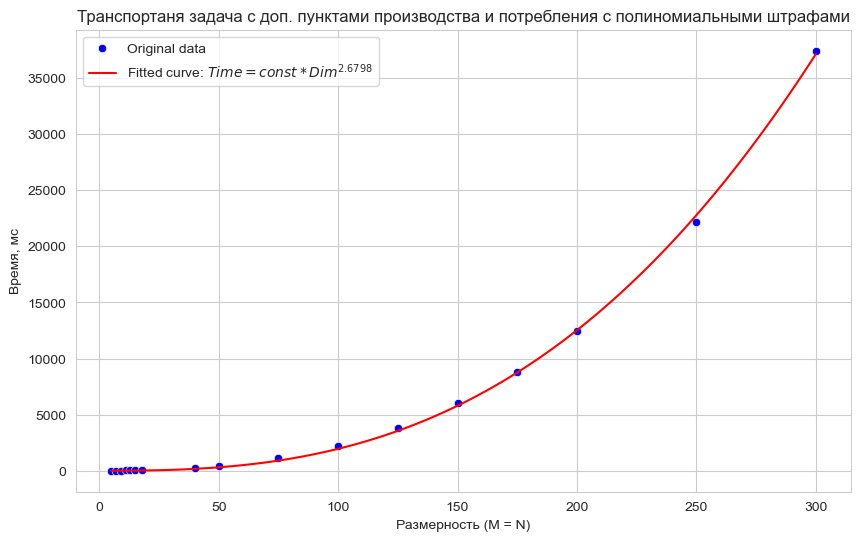

In [136]:
plot_complexity()